# phenopy disease clustering tutorial
This notebook outlines methods demonstrating how use the `phenopy` library to score and subsequently cluster groups of diseases from three different Phenotypic Series in OMIM.  

To build the groups of diseases, three Phenotypic Series were selected from OMIM.  
1. [Charcot-Marie-Tooth](https://www.omim.org/phenotypicSeries/PS118220)
2. [Spinocerebellar ataxia](https://www.omim.org/phenotypicSeries/PS164400)
3. [Bardet-Biedl syndrome](https://www.omim.org/phenotypicSeries/PS209900)

Each of these Phenotypic Series contains many "sub"-diseases, each with its own unique OMIM identifier. Diseases from the same Phenotypic Sereies generally share many similar phenotypes.  
This tutorial uses the disease-to-phenotype mapping file generated by the HPO as a data source for identifying which HPO ids (phenotypes) are associated with which OMIM ids (diseases). Simple string matching on the name of the Phenotypic Series ("Charcot-Marie-tooth", for example) is used to identify HPO ids associated with each OMIM id in the HPO mapping file.  

The notebook can be run end-to-end as long as your Python environment has the plotting libraries `matplotlib` and `seaborn` installed. If these are not installed, you can use `pip install matplotlib` and `pip install seaborn` to install them. 

In [1]:
import os
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from itertools import product

from phenopy.util import generate_annotated_hpo_network
from phenopy.score import Scorer
from phenopy.util import half_product, remove_parents

2019-12-12 11:51:13,759 - phenopy - INFO - checking if config file exists: /Users/vustach206582/.phenopy
2019-12-12 11:51:13,760 - phenopy - INFO - phenopy 0.3.2
2019-12-12 11:51:13,760 - phenopy - INFO - Using configuration file: /Users/vustach206582/.phenopy/phenopy.ini


### Initialize phenopy objects

In [2]:
# data directory
phenopy_data_directory = os.path.join(os.getenv('HOME'), '.phenopy/data')

# files used in building the annotated HPO network
obo_file = os.path.join(phenopy_data_directory, 'hp.obo')
disease_to_phenotype_file = os.path.join(phenopy_data_directory, 'phenotype.hpoa')

# if you have a custom ages_distribution_file, you can set it here.
#ages_distribution_file = os.path.join(phenopy_data_directory, 'xa_age_stats_oct052019.tsv')

hpo_network, alt2prim, disease_records = \
    generate_annotated_hpo_network(obo_file,
                                   disease_to_phenotype_file,
                                   ages_distribution_file=None
                                   )

scorer = Scorer(hpo_network)

### Parse the HPO disease to phenotype file

In [3]:
# Use the HPO's publicly available disease to phenotype mapping file.
disease_phenotype_file = 'http://compbio.charite.de/jenkins/job/hpo.annotations/lastStableBuild/artifact/misc/phenotype_annotation_new.tab'

In [4]:
response = urllib.request.urlopen(disease_phenotype_file)

In [5]:
disease1 = {}
disease2 = {}
disease3 = {}

for line in response:
    try:
        row = line.decode('utf-8').split('\t')
        db = row[0]
        db_object_id = row[1]
        db_name = row[2]
        hpo_id = row[4]
    except IndexError:
        continue
    
    if db == 'OMIM':
        if 'charcot-marie-tooth' in db_name.lower():
            if db_object_id in disease1:
                disease1[db_object_id].append(hpo_id)
            else:
                disease1[db_object_id] = [hpo_id]
        elif 'spinocerebellar ataxia' in db_name.lower():
            if db_object_id in disease2:
                disease2[db_object_id].append(hpo_id)
            else:
                disease2[db_object_id] = [hpo_id]
        elif 'bardet-biedl' in db_name.lower():
            if db_object_id in disease3:
                disease3[db_object_id].append(hpo_id)
            else:
                disease3[db_object_id] = [hpo_id]

In [6]:
print(f'Number of diseases in the CMT series: {len(disease1)}')
print(f'Number of diseases in the SCA series: {len(disease2)}')
print(f'Number of diseases in the BBS series: {len(disease3)}')

Number of diseases in the CMT series: 70
Number of diseases in the SCA series: 76
Number of diseases in the BBS series: 21


In [7]:
# merge the dictionaries
diseases = {**disease1, **disease2, **disease3}

In [8]:
print(f'Number of diseases with both series combined: {len(diseases)}')

Number of diseases with both series combined: 167


### Perform pairwise comparisons of phenotypic similarity for all disease records

In [9]:
def convert_and_filter_hpoids(terms, hpo, scorer):
    """Given a list of HPO ids, first try to convert synonyms to primary ids, 
    then filter if terms are not in the ontology"""
    terms = [alt2prim[term] if term in alt2prim else term for term in terms]
    terms = list(filter(lambda term: term in hpo.nodes, terms))
    terms = remove_parents(terms, hpo)
    return terms

In [10]:
# build the records list
# each element in the records list is a dictionary that requires at least
# 'record_id', 'terms' and 'weights' as assigned below.
records = [
    {
        'record_id': mim_id, 
        'terms': convert_and_filter_hpoids(hpo_terms, hpo_network, scorer),
        'weights': {},
    } for mim_id, hpo_terms in diseases.items()
]

### The next two cells show how to run the scoring from the imported library

In [11]:
%%time
# score the records
results = scorer.score_records(
    records,
    records,
    half_product(len(records), len(records)),
    #product((range(len(records))), range(len(records)))
)

CPU times: user 1min 39s, sys: 180 ms, total: 1min 39s
Wall time: 1min 39s


use half_product, but assign the transpose  

In [13]:
df = pd.DataFrame(results, columns=['record1', 'record2', 'phenopy-score'])
# convert to square form
df = df.set_index(['record1', 'record2']).unstack()

In [14]:
# This pandas method chain fills in the missing scores of the square matrix with the values from the transpose of df.
df = df['phenopy-score'].reset_index(drop=True).fillna(df.T.droplevel(0).reset_index(drop=True,)).set_index(df.index, drop=True)

### Plot the pairwise phenotypic similarity results

In [15]:
# get the disease label for each id
colors = {}
color_labels = {
    'r': 'Charcot-Marie-Tooth',
    'b': 'Spinocerebellar Ataxia',
    'g': 'Bardet-Biedl',
}
for omim in df.index:
    if omim in disease1:
        colors[omim] = 'r'
    elif omim in disease2:
        colors[omim] = 'b'
    elif omim in disease3:
        colors[omim] = 'g'

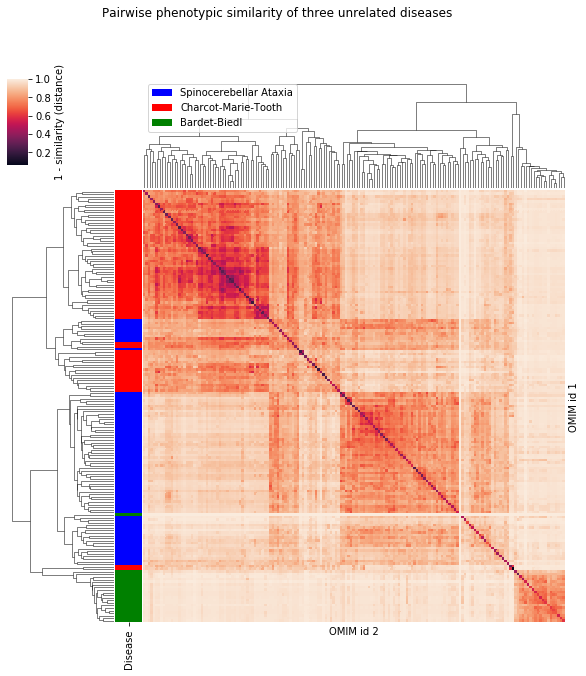

In [16]:
# 1 - df converts the similarity to a distance metric
g = sns.clustermap(1 - df.astype(float), 
                   row_colors=pd.Series(colors, name="Disease"), 
                   figsize=(10, 10),
                   xticklabels=False, 
                   yticklabels=False,
                   cbar_kws={'label': '1 - similarity (distance)'}
                   
                  )
for label in pd.Series(colors).unique():
    g.ax_col_dendrogram.bar(0, 0, color=label,
                            label=color_labels[label], linewidth=0)

g.ax_heatmap.set_xlabel("OMIM id 2");
g.ax_heatmap.set_ylabel("OMIM id 1");
g.ax_col_dendrogram.legend(loc="upper left");
g.fig.suptitle('Pairwise phenotypic similarity of three unrelated diseases');
plt.savefig('output/cluster_three_diseases.png', format='png');